# Spatially variable uplift, lithology and climate

In this module we explore how all of the forcings we might consider act in concert to modify a landscape over long-term conditions. 

## Import declarations

First we import the LandLab packages which we will be using.

In [1]:
import landlab
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, LinearDiffuser, Lithology, LithoLayers, SinkFillerBarnes
from landlab.components.flow_accum.flow_accum_bw import find_drainage_area_and_discharge
from landlab.plot import imshow_grid
import numpy as np 
import time
import matplotlib.pyplot as plt

## Importing user defined functions 

Next we import the functions which we have defined as users to model various aspects of landscape evolution. 

In [2]:
def calculate_index_max_elev(elevation):
    # calculate the max elevation along the x axis nodes (need to average over y)
    reshaped_elev = elevation.reshape(100,100)

    max_elev_x = np.max(reshaped_elev, axis = 0)

    # find the y axis index of the highest elevation point for each column.
    index_max_elev_x = np.argmax(reshaped_elev,0,keepdims=True)
    index_max_elev_x = index_max_elev_x.squeeze()
    # create a list with the column positions
    index_max_elev_y = np.arange(0,100,1)
    return index_max_elev_x, index_max_elev_y

# convert the index into the landlab grid 
def change_origin_coords(x,y, nx, ny):
    x_new = nx - x - 1
    y_new = y # this doesn't change in this case
    return x_new, y_new

def convert_coords_to_node_number(x,y, nx, ny):
    node_number = (x*ny) + (nx-y)-1 # -1 to account for starting at 0
    return node_number

# check the row position - this is with the values pre trnasformed
def windward_leeward_division(max_rows, max_cols, nx, ny):
    #precip_change = np.ones((nx, ny))
    change_factor =  np.ones((nx, ny))
    for i in range(nx):
        #print(i, max_rows[i], max_cols[i])
        change_factor[:max_rows[i],max_cols[i]]+=1
        change_factor[max_rows[i]:,max_cols[i]]+=10

    change_factor = change_factor.flatten()
    return change_factor  

def run_orographic_prec(elevation):
    index_max_elev_x, index_max_elev_y = calculate_index_max_elev(elevation)
    x_new, y_new = change_origin_coords(index_max_elev_x,index_max_elev_y, ny, ny)
    node_number = convert_coords_to_node_number(x_new,y_new, ny, ny)
    change_factor = windward_leeward_division(index_max_elev_x, index_max_elev_y, nx, ny)
    return change_factor

def choose_precip_pattern(i, precip_name,elevation, max_prec = 5):
    if precip_name == 'half_half':
        water_flux_in[grid.y_of_node>(ny*dx)/2]=1000
    elif precip_name == 'linear':
        water_flux_in[grid.y_of_node>=0] = (max_prec * grid.y_of_node)/(ny*1000)
    elif precip_name == 'orographic_simple':
        water_flux_in[grid.y_of_node>=0] = (elevation)
    else:
        precip_change_factor = run_orographic_prec(elevation)
        #orographic complex
        if i == 0 :
            water_flux_in[grid.y_of_node>=0] = (elevation)/np.max(elevation)
        if i%10==9:
            water_flux_in[grid.y_of_node>=0] = (elevation*precip_change_factor)/np.max(elevation)
            
def get_sed_flux(rmg,dz):
    '''Returns the amount of sediment (m^3) being transported across landscape for 
    a given incision map. Divide by timestep length to return as a flux.
    This just wraps the `find_drainage_area_and_discharge` function.
    ____________
    rmg = RasterModelGrid object which has `flow__upstream_node_order` and 
    `flow__receiver_node` fields defined. This can be achieved by running a
    flow-routing component. 
    
    dz = array of size == rmg.size. This specifies the vertical change in surface
    elevation for an arbitary timestep. 
    '''
    a,tot_sed_flux = find_drainage_area_and_discharge(rmg.at_node['flow__upstream_node_order'], 
                                           rmg.at_node['flow__receiver_node'],
                                           node_cell_area = float(rmg.dx*rmg.dx),
                                           runoff = dz) 
    return(tot_sed_flux)

def get_sediment_comp(rmg,dz,rock_ID):
    '''Returns the proportion of the actively transported sediment that is derived
    from the provided rock_ID
    ____________
    rmg = RasterModelGrid object which has `flow__upstream_node_order` and 
    `flow__receiver_node` fields defined. This can be achieved by running a
    flow-routing component. 
    
    dz = array of size == rmg.size. This specifies the vertical change in surface
    elevation for an arbitary timestep. 
    
    rock_ID = float; This is the numeric ID which specifies a specific rock-type defined 
    in the rmg object.  
    '''

    tot_sed_flux = get_sed_flux(rmg,dz)
    outcrop_loc = rmg.at_node['rock_type__id']==rock_ID # Spatial map showing where particular rock type outcrops
    a, tot_rock_sed_flux = find_drainage_area_and_discharge(rmg.at_node['flow__upstream_node_order'], 
                                           rmg.at_node['flow__receiver_node'],
                                           node_cell_area = float(rmg.dx*rmg.dx),
                                           runoff = dz*outcrop_loc)
    with np.errstate(divide='ignore',invalid='ignore'): # Just to suppres div by zero warnings
        proportion=tot_rock_sed_flux/tot_sed_flux
    return(proportion)            
    

## Initialise Grid

We initialise the LandLab grid as in the previous examples.

In [3]:
nx = 100 # number of grid cells (x)
ny = 100 # number of grid cells (y)
dx = 1000 # metres

grid = RasterModelGrid((nx,ny),dx,xy_axis_units='m')
elev = grid.add_zeros('topographic__elevation',at='node')
water_flux_in = grid.add_ones("water__unit_flux_in", at="node")
grid.set_closed_boundaries_at_grid_edges(True,False,True,False)

np.random.seed(1)
elev[grid.core_nodes]+=np.random.uniform(0,10,size=elev.size)[grid.core_nodes]

## Initialise Components

Now we initialise the components which are choosing to use. 

In [4]:
sb = SinkFillerBarnes(grid, method='D8')
sb.run_one_step()

fr = FlowAccumulator(grid, flow_director='D8')
fr.run_one_step()

n_sp = 1
m_sp = 0.5 
K_sp = 1e-3 #m/kyr 
D_diff = 100 # m^2/kyr
diff = LinearDiffuser(grid,linear_diffusivity=D_diff)
sp = FastscapeEroder(grid, K_sp=K_sp,m_sp=m_sp,n_sp=n_sp)
peclet = ((nx*dx)*K_sp)/D_diff
dt_max_adv = grid.dx/K_sp
dt_max_diff = (grid.dx)**2/D_diff

print("Advective stability condition: t < ",dt_max_adv, "kyr")
print("Diffusive stability condition: t < ",dt_max_diff, "kyr")

Advective stability condition: t <  1000000.0 kyr
Diffusive stability condition: t <  10000.0 kyr


Now we combine all of the variables into a 'realistic' landscape where by all of the above forcing conditions (variable uplift, spatially changing precipitation and layers of variable strength lithology) are considered.

The scenario we are going to consider is a stratigraphic column with varying rock strength which uplifts to form an anticline structure into a dome, forced with orographic rainfall.  

## Defining stratigraphic column

We first define 10 flat lithological layers (stored in `layer_elevations`). The _bottom_ boundaries of these layers lie every 500 metres below the surface.

We assign each of these layers a different rock ID (`layer_ids`) so they can be distinguished. Next, we give each of these rock IDs a different erodibility ($K_{sp}$). The units roughly get stronger with depth but to make it more 'realistic' we add some random uniform noise to the K_sp so that the strength change is a bit more random.

In [5]:
np.random.seed(2) # Set random seed 
layer_elevations = np.arange(0,5500,500) # Set the layers to be 500m thick down to 5km depth 
layer_elevations[-1] = 10000 # Set final layer to be super thick so we never erode through it
layer_ids = np.arange(11) # Set layer IDs
k_sp = np.linspace(-2,-4,11) # Initially K_sp decreases with depth (i.e. stronger with depth)
k_sp+=np.random.uniform(-1,1,11) # But we add some random noise to consider lithological vagaries

# Set the attributes dictionary
attrs = {'K_sp':{}}
k_sp
layer_ids
for i in layer_ids:
    attrs['K_sp'][i] = 10**(k_sp[i])

lith = LithoLayers(grid, layer_elevations, ids= layer_ids, attrs=attrs) # Initiate LithoLayers
sp_lith = FastscapeEroder(grid, K_sp='K_sp',m_sp=m_sp,n_sp=n_sp,discharge_field='surface_water__discharge') # Link up erodibility to Fastscaper

The changing rock strength and ID with depth is shown below.

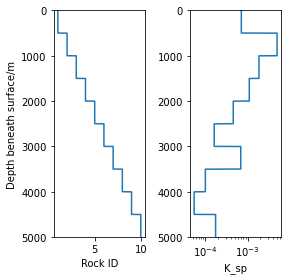

In [6]:
id_arr = np.zeros(np.max(layer_elevations))
ksp_arr = np.zeros(np.max(layer_elevations))
for i in np.arange(layer_ids.size):
    elevation = layer_elevations[i]
    layer_id = layer_ids[i]
    ksp = attrs['K_sp'][layer_id]
    if(i==0):
        id_arr[0:elevation] = layer_id
        ksp_arr[0:elevation] = ksp
    else:
        id_arr[layer_elevations[i-1]:elevation] = layer_id
        ksp_arr[layer_elevations[i-1]:elevation] = ksp    
        
plt.figure(figsize=(4,4))
plt.subplot(1,2,2)        
plt.plot(ksp_arr,np.arange(np.max(layer_elevations)))
plt.xscale('log')
plt.xlabel("K_sp")
plt.ylim(0,5000)
plt.gca().invert_yaxis()

plt.subplot(1,2,1)
plt.plot(id_arr,np.arange(np.max(layer_elevations)))
plt.tight_layout()
plt.xlabel("Rock ID")
plt.ylabel("Depth beneath surface/m")
plt.ylim(0,5000)
plt.gca().invert_yaxis()
plt.show()

## Defining the uplift rate 

We are aiming to recreate the scenario of an uplifting dome, hence we use a parabolic uplift rate with a maximum uplift rate of 0.1 m/kyr. This is demonstrated below. 

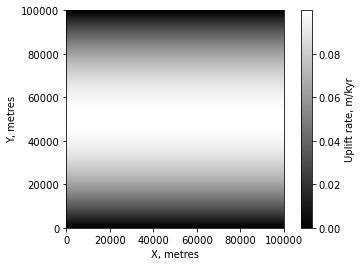

In [7]:
#uplift_rate = a(y-h)^2 +k
#In this case, we assume maximum uplift rate (Umax) = 0.1 at the middle of the area 
#The highest uplift area is at the middle area
#-----> at y = h -> uplift_rate = 0.1
Umax = 0.1
h = (max(grid.y_of_node)-min(grid.y_of_node))/2
k = Umax
# and minimum uplift rate (Umin) = 0 at top and bottom boundary 
# -----> at y = Ymin and Y=Ymax -> uplift_rate = 0
Umin = 0.0
a= (Umax-Umin)/(-(max(grid.y_of_node)-h)**2)
uplift_rate = np.zeros(grid.number_of_nodes)
uplift_rate = a*(grid.y_of_node - h)**2+k

plt.imshow(uplift_rate.reshape(grid.shape),origin='lower',extent=(0,100000,0,100000),cmap='gray')
plt.xlabel("X, metres") 
plt.ylabel("Y, metres")
cb = plt.colorbar()
cb.set_label("Uplift rate, m/kyr")

Now we have a system of uniformly eroded rocks. We progressively erode down through these units using the same initial model setup as above. Whenever we feed in uplift to our landscape we need to vertically _advect_ the lithologies upwards as well, this simulates progressive uplift of a stratigraphically layered unit.  

The chunk below outputs the topography, and the 'geological map' at 2.5 Myr timesteps. 

Running for 500 iterations


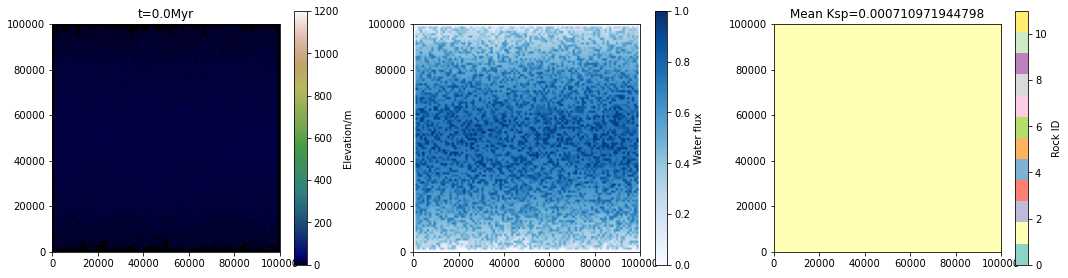

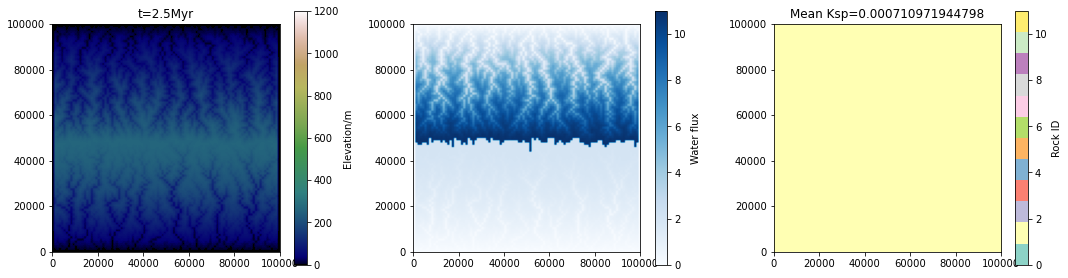

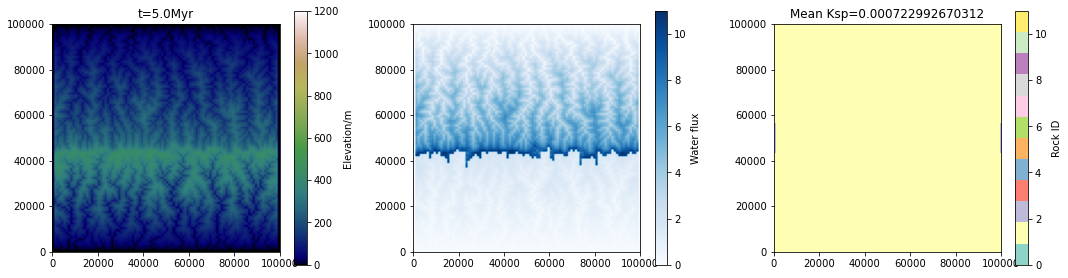

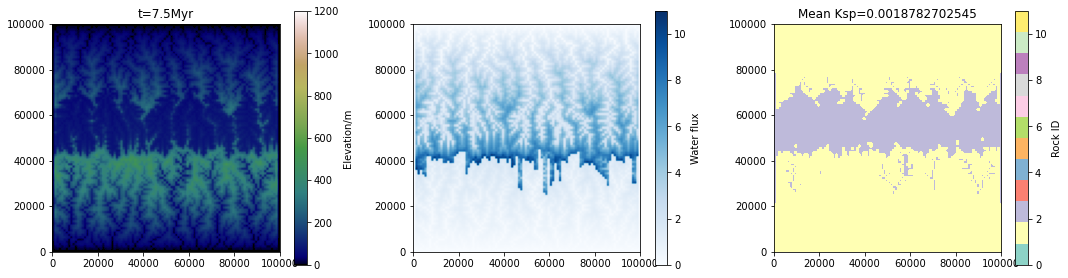

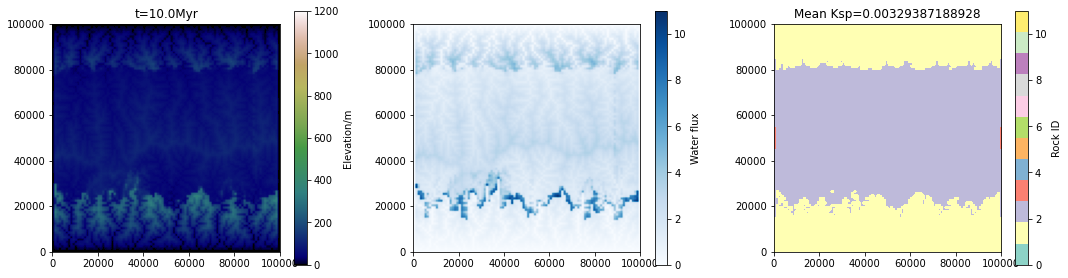

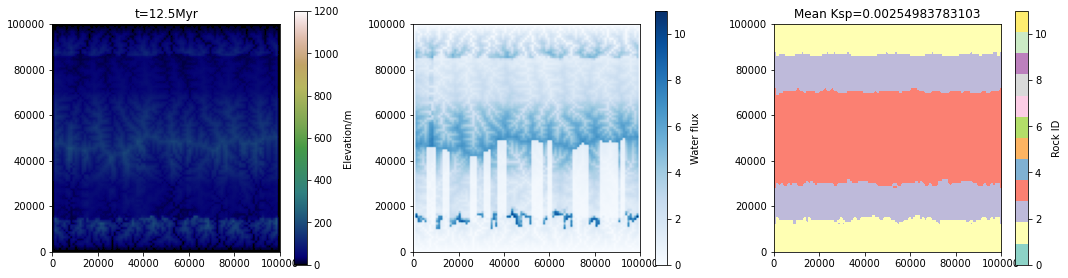

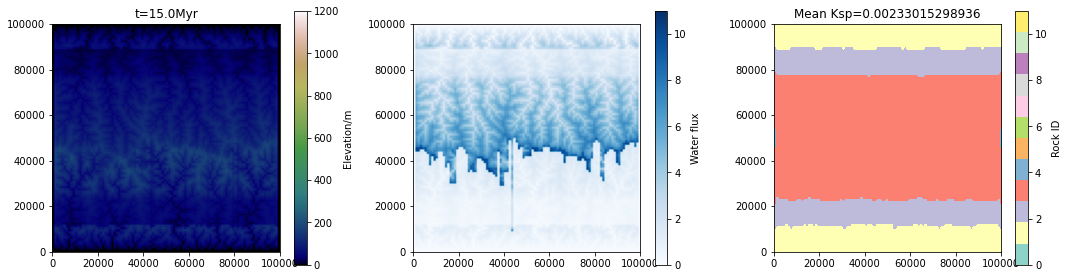

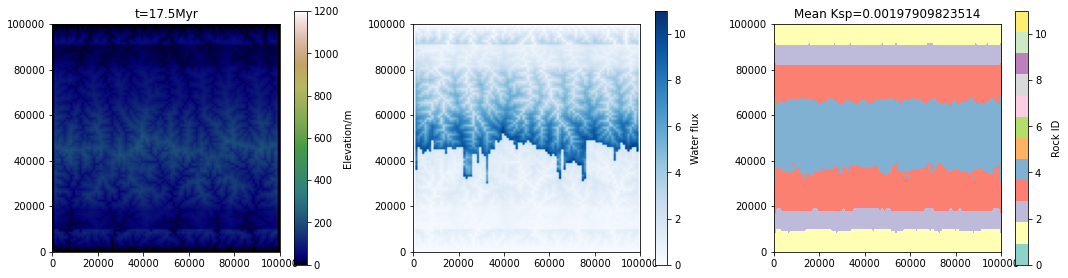

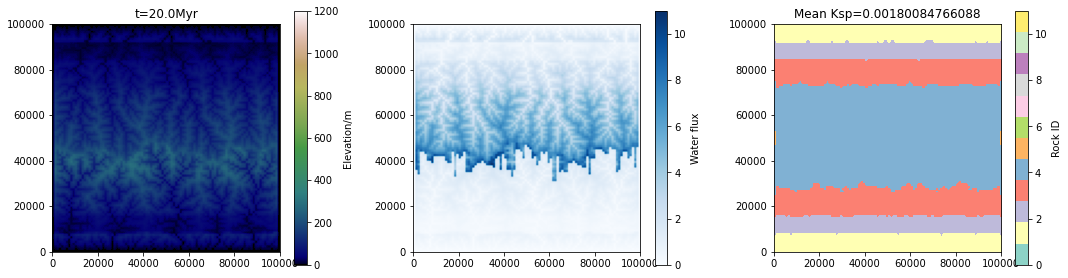

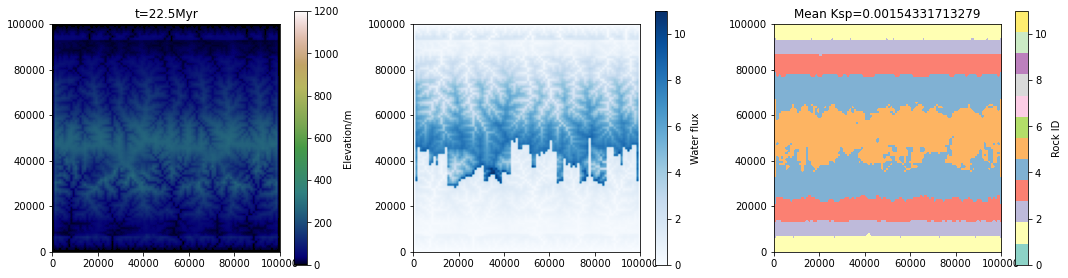

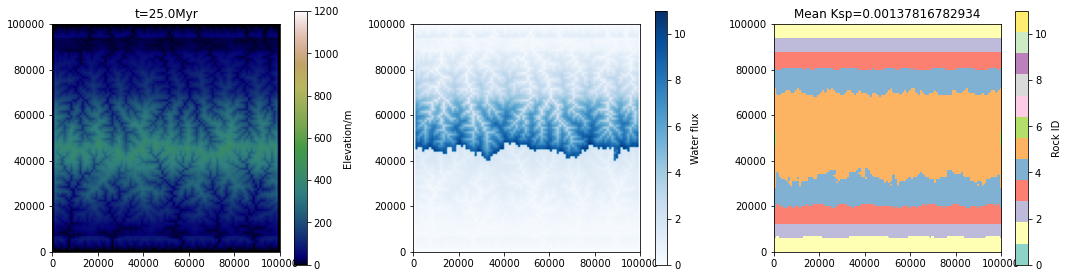

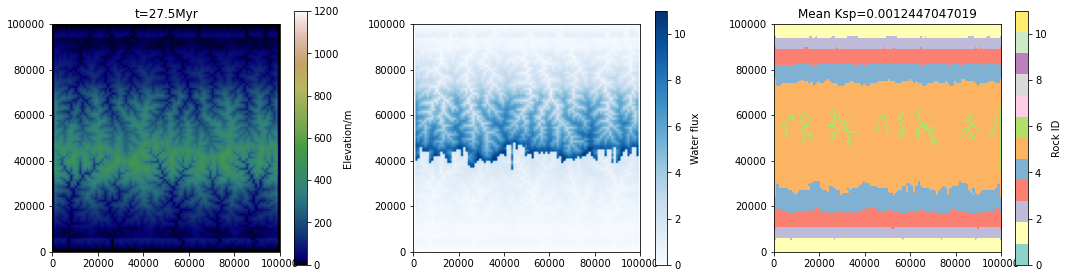

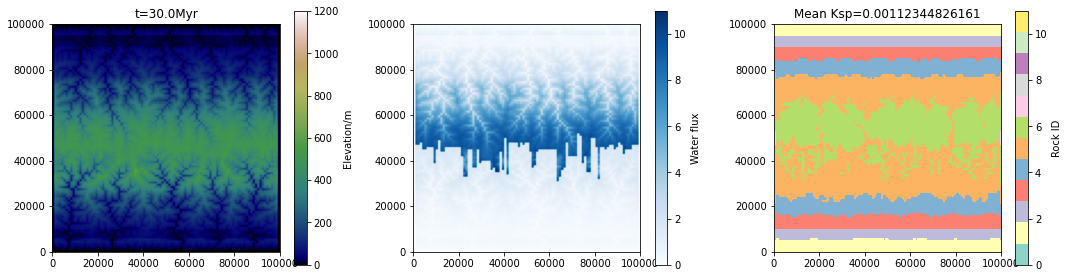

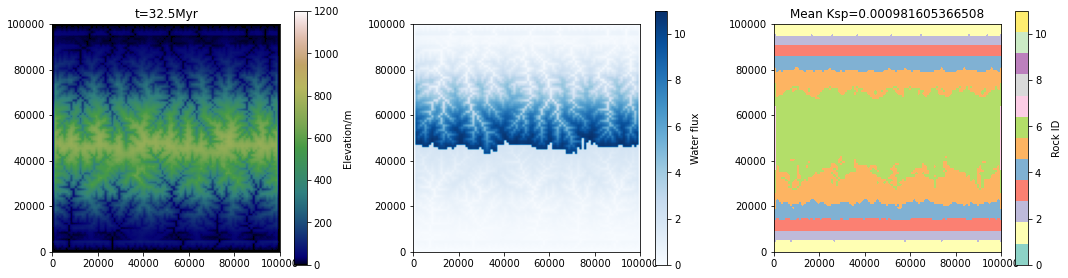

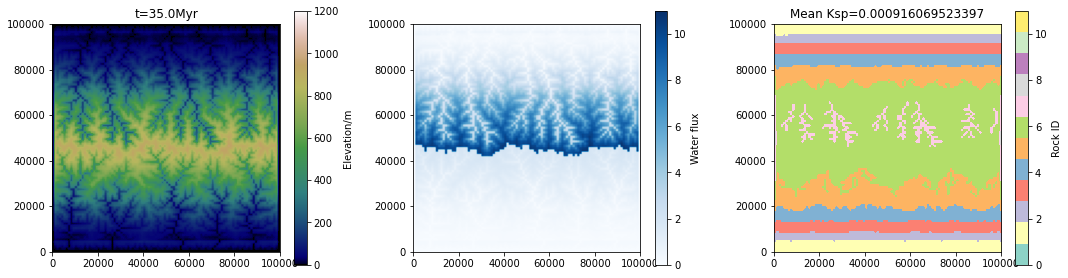

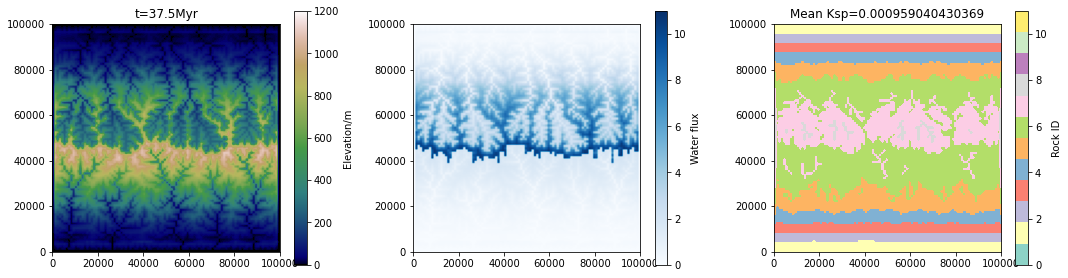

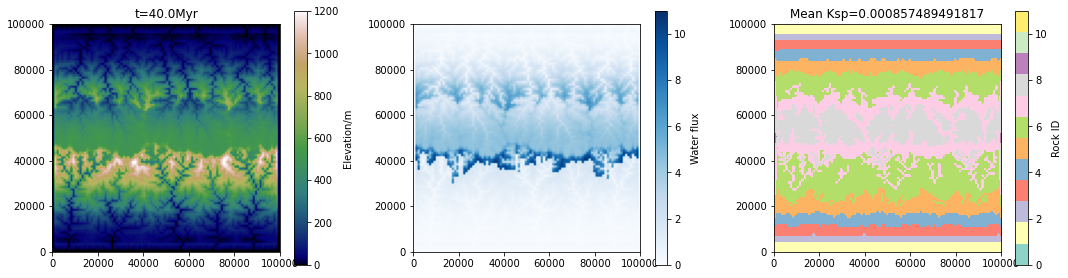

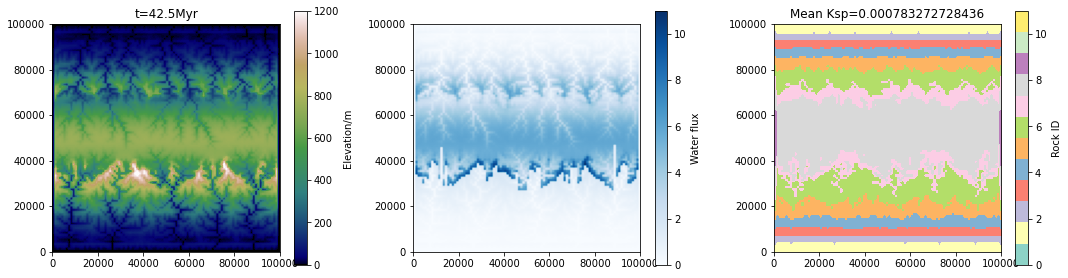

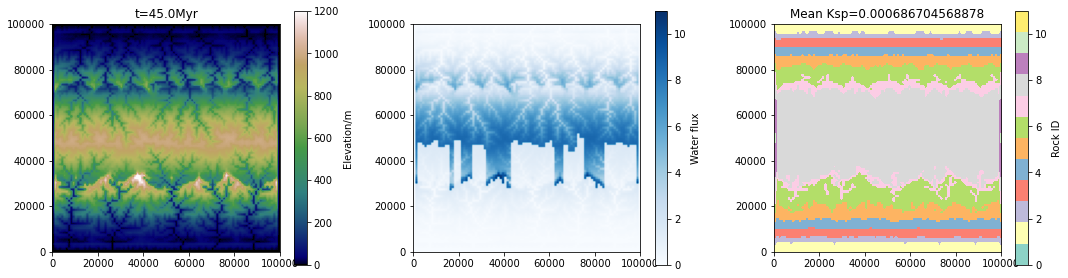

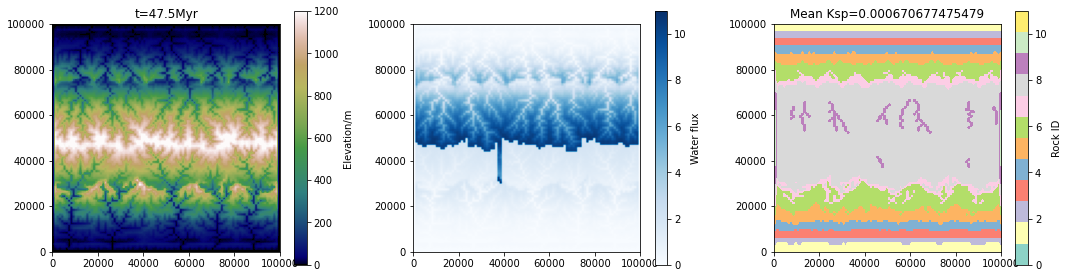

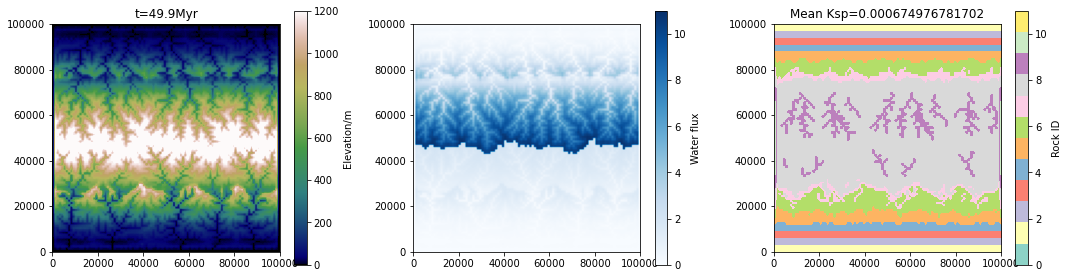

In [8]:
dt = 100 # 100 kyr
runtime= 50000 # 50000 kyr = 50 Myr
n_steps = runtime//dt 
print("Running for", n_steps, "iterations")

sed_comp_record = np.zeros((n_steps,layer_ids.size)) # Initialise output sed. comp. array.
sed_flux_record = np.zeros((n_steps,1)) # Initialise output sed. flux. array.

for i in np.arange(n_steps):
    t=i*dt
    fr.run_one_step() # Flow-route
    elev_old = np.copy(elev) # Cache a copy of the elevation *before* erosion    
    sp_lith.run_one_step(dt) # Erode the landscape one step
    elev_new = np.copy(elev) # Cache a copy of the elevation *after* erosion
    dz = elev_old-elev_new # Vertical change in elevation    
    uplift_step = uplift_rate * dt # Define the increase in elevation due to tectonic uplift
    dz_adv = uplift_step # Set the lithological advection to the tectonic uplift
    
    sed_flux_at_margin = get_sed_flux(grid,dz)[grid.y_of_node==0] # Extract the sediment flux along the southern margin
    tot_sed_at_margin = np.sum(sed_flux_at_margin) # Total flux coming out southern margin
    sed_flux_record[i] = tot_sed_at_margin # Update the out array of sediment flux 
    for rock_type in layer_ids: # Loop through each rock type ID
        sed_comp_at_margin = get_sediment_comp(grid,dz,rock_type)[grid.y_of_node==0] # Calculate sediment comp along southern margin
        sed_comp_record[i,rock_type] = np.nansum(sed_comp_at_margin*sed_flux_at_margin)/tot_sed_at_margin # Convert to *average* sediment comp at margin
    
    elev[grid.core_nodes] += uplift_step[grid.core_nodes] # Uplift the landscape
    choose_precip_pattern(i, 'orographic_complex', elev) # Update orographic rainfall    
    lith.dz_advection=dz_adv # Set the advection of the litholayers object
    lith.run_one_step() # Advect the litholayers upwards
    
    if(t%2500==0):
        plt.figure(figsize=(15,4))
        plt.subplot(1,3,1) # Add a subplot
        plt.imshow(grid.node_vector_to_raster(elev),cmap='gist_earth',vmin=0,vmax=1200,extent=(0,100000,0,100000),origin='lower') # Plot topo
        plt.title("t="+str(t/1000)+"Myr") 
        cb = plt.colorbar()
        cb.set_label("Elevation/m")
        plt.subplot(1,3,2) # Add a subplot
        plt.imshow(grid.node_vector_to_raster(grid.at_node['water__unit_flux_in']),cmap='Blues',extent=(0,100000,0,100000),origin='lower') # Plot Rainfall    
        cb = plt.colorbar()
        cb.set_label("Water flux")
        plt.subplot(1,3,3)
        plt.imshow(grid.node_vector_to_raster(grid.at_node['rock_type__id']),cmap='Set3',vmin=0,vmax=11,extent=(0,100000,0,100000),origin='lower') # Plot rock-type
        plt.title("Mean Ksp="+str(np.mean(grid.at_node['K_sp']))) # Display the average erodibility of the landscape
        cb = plt.colorbar()
        cb.set_label("Rock ID")
        plt.tight_layout()
        plt.show()
           
# Plot the final timestep
plt.figure(figsize=(15,4))
plt.subplot(1,3,1) # Add a subplot
plt.imshow(grid.node_vector_to_raster(elev),cmap='gist_earth',vmin=0,vmax=1200,extent=(0,100000,0,100000),origin='lower') # Plot topo
plt.title("t="+str(t/1000)+"Myr") 
cb = plt.colorbar()
cb.set_label("Elevation/m")
plt.subplot(1,3,2) # Add a subplot
plt.imshow(grid.node_vector_to_raster(grid.at_node['water__unit_flux_in']),cmap='Blues',extent=(0,100000,0,100000),origin='lower') # Plot Rainfall    
cb = plt.colorbar()
cb.set_label("Water flux")
plt.subplot(1,3,3)
plt.imshow(grid.node_vector_to_raster(grid.at_node['rock_type__id']),cmap='Set3',vmin=0,vmax=11,extent=(0,100000,0,100000),origin='lower') # Plot rock-type
plt.title("Mean Ksp="+str(np.mean(grid.at_node['K_sp']))) # Display the average erodibility of the landscape
cb = plt.colorbar()
cb.set_label("Rock ID")
plt.tight_layout()
plt.show()

Here we see that as rocks of varying strengths are eroded we form ridges parallel to the anticline. The orographic rainfall also means that the anticline itself is asymmetrical. The, on average, increasing strength with depth means that the topography increases with time as the harder core is exposed.  

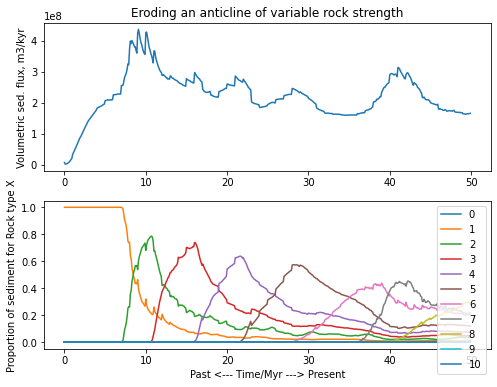

In [9]:
time=np.arange(0,runtime,dt)
plt.figure(figsize=(8,6))
plt.subplot(2,1,1)
plt.title("Eroding an anticline of variable rock strength")
plt.plot(time/1000,sed_flux_record/dt)
plt.ylabel("Volumetric sed. flux, m3/kyr")

plt.subplot(2,1,2)
plt.plot(time/1000,sed_comp_record,label=layer_ids)
plt.xlabel("Past <--- Time/Myr ---> Present")
plt.ylabel("Proportion of sediment for Rock type X")
plt.legend()
plt.show()

Finally we can track the changing sediment provenance through time as well as the total sedimentary flux. We see that the complex lithological structure means that whilst uplift is constant we see significant changes in sediment flux and provenance through time.  